In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Users\kzvda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
path=r'test_data.csv'

csv=read_csv(path, index_col='Date/Time', parse_dates=True).sort_index()

dataset, x_scaler, y_scaler = create_dataset(csv, 24)

train_size = int(len(dataset) * 0.67)

train_x, train_y, test_x, test_y = split_data(dataset, train_size)

train_x, test_x = reshape(train_x), reshape(test_x)

model = run(train_x, train_y, test_x, test_y, False)


Train on 6335 samples, validate on 3121 samples
Epoch 1/50
6335/6335 [==============================] - 17s 3ms/step - loss: 0.0982 - val_loss: 0.0555
Epoch 2/50
6335/6335 [==============================] - 18s 3ms/step - loss: 0.0808 - val_loss: 0.0387
Epoch 3/50
6335/6335 [==============================] - 15s 2ms/step - loss: 0.0676 - val_loss: 0.0457
Epoch 4/50
6335/6335 [==============================] - 15s 2ms/step - loss: 0.0588 - val_loss: 0.0271
Epoch 5/50
6335/6335 [==============================] - 15s 2ms/step - loss: 0.0588 - val_loss: 0.0244
Epoch 6/50
6335/6335 [==============================] - 16s 2ms/step - loss: 0.0587 - val_loss: 0.0210
Epoch 7/50
6335/6335 [==============================] - 16s 2ms/step - loss: 0.0633 - val_loss: 0.0200
Epoch 8/50
6335/6335 [==============================] - 16s 3ms/step - loss: 0.0584 - val_loss: 0.0162
Epoch 9/50
6335/6335 [==============================] - 17s 3ms/step - loss: 0.0569 - val_loss: 0.0226
Epoch 10/50
6335/6335 [==

Train Score: 0.24 RMSE
Test Score: 0.06 RMSE


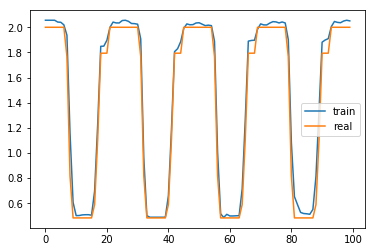

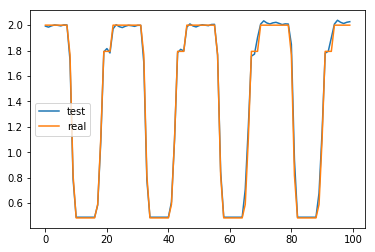

In [11]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)
# invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([train_y])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([test_y])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(trainPredict[0:100], label='train')
plt.plot(trainY[0][0:100], label='real')
plt.legend()
plt.show()

plt.plot(testPredict[0:100], label='test')
plt.plot(testY[0][0:100], label='real')
plt.legend()
plt.show()

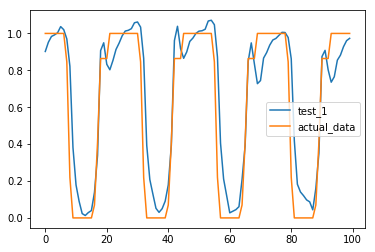

In [16]:
# path=r'office_test.csv'
path=r'test_data_2.csv'
data_1 = test(model,path)

num = 100
# plt.plot(trainPredict[0:num], label='train')
plt.plot(data_1[0:num], label='test_1')

csv=read_csv(path, index_col='Date/Time', parse_dates=True).sort_index()

dataset, x_scaler, y_scaler = create_dataset(csv, 24)

actual_data = dataset.values[:,-1]


plt.plot(actual_data[0:num], label='actual_data')

# csv=read_csv(path, index_col='Date/Time', parse_dates=True).sort_index()

# dataset, x_scaler, y_scaler = create_dataset(csv,7)

# train_size = int(len(dataset) * 0.67)

# train_x, train_y, test_x, test_y = split_data(dataset, train_size)

# train_x, test_x = reshape(train_x), reshape(test_x)

# model.fit(train_x, train_y, epochs=50, batch_size=50, validation_data=(test_x, test_y), verbose=2, shuffle=False)


plt.legend()
plt.show()

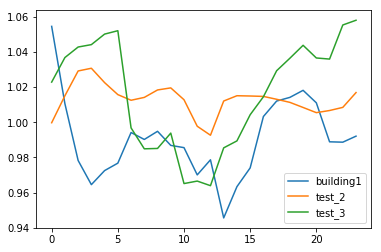

In [17]:
num = 24
path=r'building1_data.csv'

data_1 = test(model,path)

plt.plot(data_1[:num], label='building1')
plt.plot(data_1[num:num*2], label='test_2')
plt.plot(data_1[num*2:num*3], label='test_3')

# path=r'building3_data.csv'
# data_2 = test(model,path)

# plt.plot(data_2[:num], label='building3')

# path=r'building4_data.csv'
# data_2 = test(model,path)

# plt.plot(data_2[:num], label='building4')

plt.legend()
plt.show()

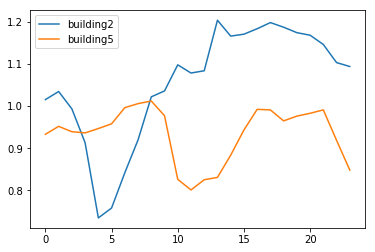

In [18]:
num = 24
path=r'building2_data.csv'
data_2 = test(model,path)

plt.plot(data_2[:num], label='building2')

path=r'building5_data.csv'
data_2 = test(model,path)

plt.plot(data_2[:num], label='building5')


plt.legend()
plt.show()

In [15]:
def series_to_supervised(data, prediction_data, n_in=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    cols.append(DataFrame(prediction_data))
    names += ['var1(t)']
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def create_dataset(csv, num):
    # load dataset
    dataset = csv.loc[csv.index,['env_temp','u_temp','u_energy']].sort_index()
    test_data = csv.loc[csv.index,['u_occup']].sort_index()
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    x_scaled = x_scaler.fit_transform(values)
    y_scaler = MinMaxScaler(feature_range=(0, 1));
    y_scaled = y_scaler.fit_transform(test_data);

    reframed = series_to_supervised(x_scaled,y_scaled, num)
    
    return reframed, x_scaler, y_scaler

def create_testset(csv, num):
    # load dataset
    dataset = csv.loc[csv.index,['env_temp','u_temp','u_energy']].sort_index()
    test_data = csv.loc[csv.index,['env_temp']].sort_index()
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    x_scaled = x_scaler.fit_transform(values)
    y_scaler = MinMaxScaler(feature_range=(0, 1));
    y_scaled = y_scaler.fit_transform(test_data);

    reframed = series_to_supervised(x_scaled,y_scaled, num)
    return reframed, y_scaler

def split_data(dataset, train_length):
    # split into train and test sets
    values = dataset.values
    train_size = train_length
    test_size = len(dataset) - train_size
    train_x, train_y = values[0:train_size,:-1],values[0:train_size,-1]
    test_x, test_y = values[train_size:len(dataset),:-1], values[train_size:len(dataset),-1]
    return train_x, train_y, test_x, test_y

def reshape(data_x):
    # reshape input to be [samples, time steps, features]
    data = np.reshape(data_x, (data_x.shape[0], 1, data_x.shape[1]))
    return data

def run(train_x, train_y, test_x, test_y, show=True, verbose=1):
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
#     model.add(LSTM(50,return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
#     model.add(LSTM(50,return_sequences=True))
#     model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_x, train_y, epochs=50, batch_size=1, validation_data=(test_x, test_y), verbose=verbose, shuffle=False)
    if show:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    return model

def train_nn(path):
    csv=read_csv(path, index_col=0, parse_dates=True).sort_index()
    
    dataset = create_dataset(csv)
    
    train_x, train_y, test_x, test_y = split_data(dataset)
    
    train_x, test_x = reshape(train_x), reshape(test_x)
    
    model = run(train_x, train_y, test_x, test_y)
    return model

def test(model, path):
    csv=read_csv(path, index_col=0, parse_dates=True).sort_index()

    dataset, y_scaler = create_testset(csv, 24)

    # split into train and test sets
    values = dataset.values
    test_x = values[:,:-1]

    test_x = reshape(test_x)

    predict = model.predict(test_x)

#     predict = y_scaler.inverse_transform(predict)
    return predict